In [299]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [300]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [301]:
len(words)

32033

In [302]:
# build the vocabuary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i +1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [303]:
# building the dataset
block_size = 3 #how many characters do we take to predict the next one
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [304]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [305]:
# split into training, dev/validation, test split to avoid over fitting and under fitting
# 80%, 10% 10% 

In [307]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# lets crank the characters into a custom dimensional space
C = torch.randn((27, 2))

In [ ]:
C[X].shape

torch.Size([228146, 3, 2])

In [326]:
# embedding
emb= C[Xtr]
emb.shape

torch.Size([182580, 3, 2])

In [ ]:
# concantenate using view but -1 to enable torch inger the right size based on the precedent size
W1 = torch.randn((6, 100))
b1 = torch.randn(100)


In [ ]:
embV = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(embV)

In [ ]:
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob[0]

tensor([8.9271e-04, 2.0972e-10, 2.1396e-09, 4.2162e-05, 2.0977e-05, 7.2209e-08,
        1.1869e-05, 3.9335e-03, 2.1554e-06, 3.0588e-08, 1.0598e-06, 1.5665e-09,
        3.1430e-01, 9.8393e-10, 1.7135e-08, 1.2831e-05, 7.3552e-06, 8.7765e-06,
        2.2365e-05, 6.7953e-01, 6.9767e-07, 3.0472e-09, 2.2727e-04, 4.9152e-05,
        1.9700e-09, 9.3569e-04, 1.9805e-10])

In [ ]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [308]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [367]:
g = torch.Generator().manual_seed(2147483647) # for reproductivity
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b2, W1, b2]

In [363]:
# number of parameters in total
sum(p.nelement() for p in parameters)

12324

In [368]:
for p in parameters:
    p.requires_grad = True

In [309]:
# stabilize the learning rate
lre = torch.linspace(-3, 0, 1000) # learning rate exponential
# lrs = torch.exp(lre)
lrs = 10**lre


In [334]:
Xtr.shape[0]

182580

In [399]:
lri = []
lossi = []
stepi = []

In [410]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 #(32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

# track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

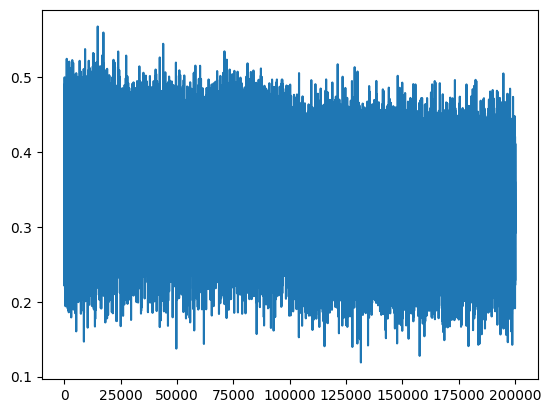

In [411]:
plt.plot(stepi, lossi)

In [403]:
print(loss.item()) 

2.6283633708953857


In [412]:
# forward pass
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1470, grad_fn=<NllLossBackward0>)

In [413]:
# forward pass
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30 ) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1786, grad_fn=<NllLossBackward0>)

In [374]:
# plt.plot(lri, lossi)

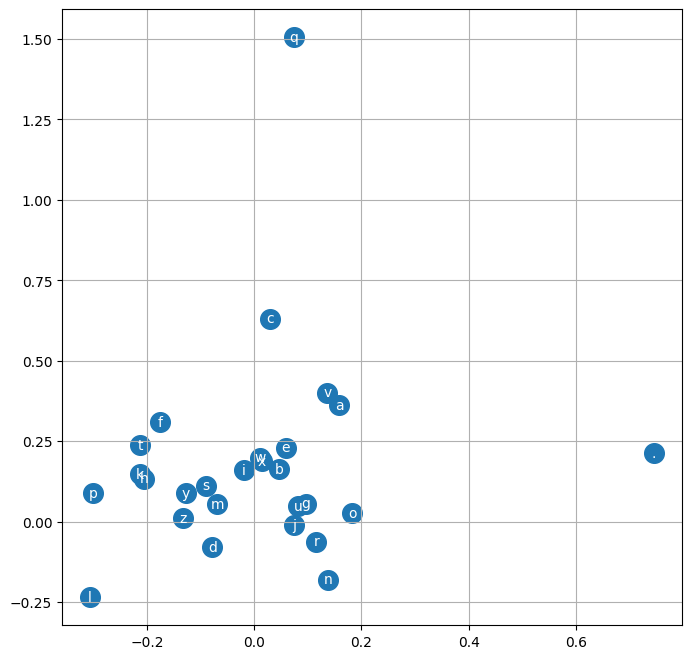

In [397]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [417]:
# sample from the network

for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

azmerober.
eliya.
rohannie.
elina.
achy.
jamikelerie.
mari.
mah.
rylingsley.
neeys.
nax.
coben.
wen.
genny.
mak.
kydin.
giar.
leigonny.
way.
klan.


In [ ]:
# let us infer a minibatch to save the NN from taking on too much at a time

torch.randint(0, X.shape[0], (32,)).shape

torch.Size([32])

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([1.5988, 4.2595, 2.1688, 2.0830, 2.2983, 1.9719, 1.5988, 1.7469, 2.0649,
        1.7365, 2.1566, 1.6348, 2.9471, 1.9044, 3.0296, 1.8141, 1.7365, 1.5003,
        1.9932, 2.2448, 2.0914, 2.3320, 2.2010, 1.9666, 2.6070, 2.1784, 2.0046,
        2.1909, 1.7365, 1.7365, 1.8599, 1.6266], grad_fn=<MaxBackward0>),
indices=tensor([12, 12,  1,  5,  0,  5, 12,  0,  1,  1,  0, 12,  0,  1,  5,  0,  1, 12,
         5,  0,  0,  5,  0,  5,  0,  5,  1,  1,  1,  1,  0,  5]))

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])